Solaris installation with gdal\
!add-apt-repository ppa:ubuntugis/ppa -y\
!apt-get update\
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [ ]:
!pip3 install torch torchvision
!pip3 install py7zr
!pip3 install rasterio

Solaris installation

In [ ]:
!add-apt-repository ppa:ubuntugis/ppa -y
!apt-get update
!apt-get install python-numpy gdal-bin libgdal-dev python3-rtree\

!pip install solaris==0.2.0

In [4]:
import torch
import rasterio
import py7zr
import os
import numpy as np
import pandas as pd
import solaris as sol
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from torch import nn
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

load dataset from github\
repo path : https://github.com/AnupamaRajkumar/LandfillDataset.git


In [7]:
#!apt-get update && apt-get upgrade
#!apt-get install git-lfs

Use this if downloading from git (ie. LFS quota available!)

In [8]:
#!git lfs clone https://github.com/AnupamaRajkumar/LandfillDataset.git

Extract the imaages from zip folder

In [6]:
def ExtractFiles(in_path, out_path):
  with py7zr.SevenZipFile(in_path, mode='r') as z:
    z.extractall(out_path)

Use following functions downloading dataset from dropbox

Multispectral dataset

In [7]:
def DownloadMultiSpectralDataset():
  !wget https://www.dropbox.com/s/go95ez8lez9113y/MultiSpectral.7z?dl=0
  os.rename('MultiSpectral.7z?dl=0', 'Multispectral.7z')
  ExtractFiles('Multispectral.7z', './')

Pansharpened dataset

In [8]:
def DownloadPanSharpenedDataset():
  !wget https://www.dropbox.com/s/qb0dfxjafuodc27/Pansharpened.7z?dl=0
  os.rename('Pansharpened.7z?dl=0', 'Pansharpened.7z')
  ExtractFiles('Pansharpened.7z', './')


In [9]:
DownloadMultiSpectralDataset()

--2021-04-05 17:04:51--  https://www.dropbox.com/s/go95ez8lez9113y/MultiSpectral.7z?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/go95ez8lez9113y/MultiSpectral.7z [following]
--2021-04-05 17:04:52--  https://www.dropbox.com/s/raw/go95ez8lez9113y/MultiSpectral.7z
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uceb3c1b92d9cb0b3146bcdad160.dl.dropboxusercontent.com/cd/0/inline/BMDcQyaTyMXFCby1lIwHzSKl1cPrkoVQUNTQUbSMl-d0StL2MwnJfDNrAyegnQinZvfE74kuBhdzLZ630cjoFNkj-x7JAhMUqNPFToXWLgKb6CW_7wuhsMt2v-9qZZTbgxvsSgbCdwX_RYLHjPepXx0x/file# [following]
--2021-04-05 17:04:52--  https://uceb3c1b92d9cb0b3146bcdad160.dl.dropboxusercontent.com/cd/0/inline/BMDcQyaTyMXFCby1lIwHzSKl1cPrkoVQUNTQUbSMl-d0StL2MwnJfDNrAyegnQinZvfE74

Declaring paths

In [10]:

#All the paths related to multispectral dataset
Multispectral_path = './Multispectral.7z'                                       #path of zip files
TIF_file_path = './MultiSpectral/HR_TIF_Files.7z'
JSON_file_path = './MultiSpectral/LandfillCoordPolygons.7z'
json_path = './LandfillCoordPolygons'
train_path = './HR_TIF_Files'
train_labels = './MultiSpectral/MultiSpectralData.csv'

#All the paths related to pansharpened datset
Pansharpened_path = './Pansharpened.7z'
PanSharpened_TIF_file_path = './Pansharpened/HR_TIF_Files.7z'

#Output directory path
out_path = './'                                                                 #output path of extracted files

#dimensions of the figure to be displayed
width = 15
height = 15

Extracting the multispectral dataset\
Run this cell if working with multispectral dataset

In [11]:
#extract multispectral images
ExtractFiles(TIF_file_path , out_path)
#extract multispectral json files
ExtractFiles(JSON_file_path , out_path)

Extracting the pansharpened dataset\
Run this cell if working with pansharpened dataset

In [ ]:
 """ 
  #extract pansharpened images
  ExtractFiles(PanSharpened_TIF_file_path , out_path)
  #extract multispectral json files
  #ExtractFiles(JSON_file_path , out_path)
"""

Displaying a few images from the folder

Number of training images: 146
-------------multispectral images----------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512)
image :  00106_Nurnberg_Germany.tif channels : 4
(512, 512)
image :  00085_Malta_France.tif channels : 8
(512, 512)
image :  00094_Mumbai_India.tif channels : 4
(512, 512)
image :  00075_Hannover_Germany.tif channels : 8
(512, 512)
image :  00105_Nurnberg_Germany.tif channels : 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 512)
image :  000140_Vinca_Serbia.tif channels : 8


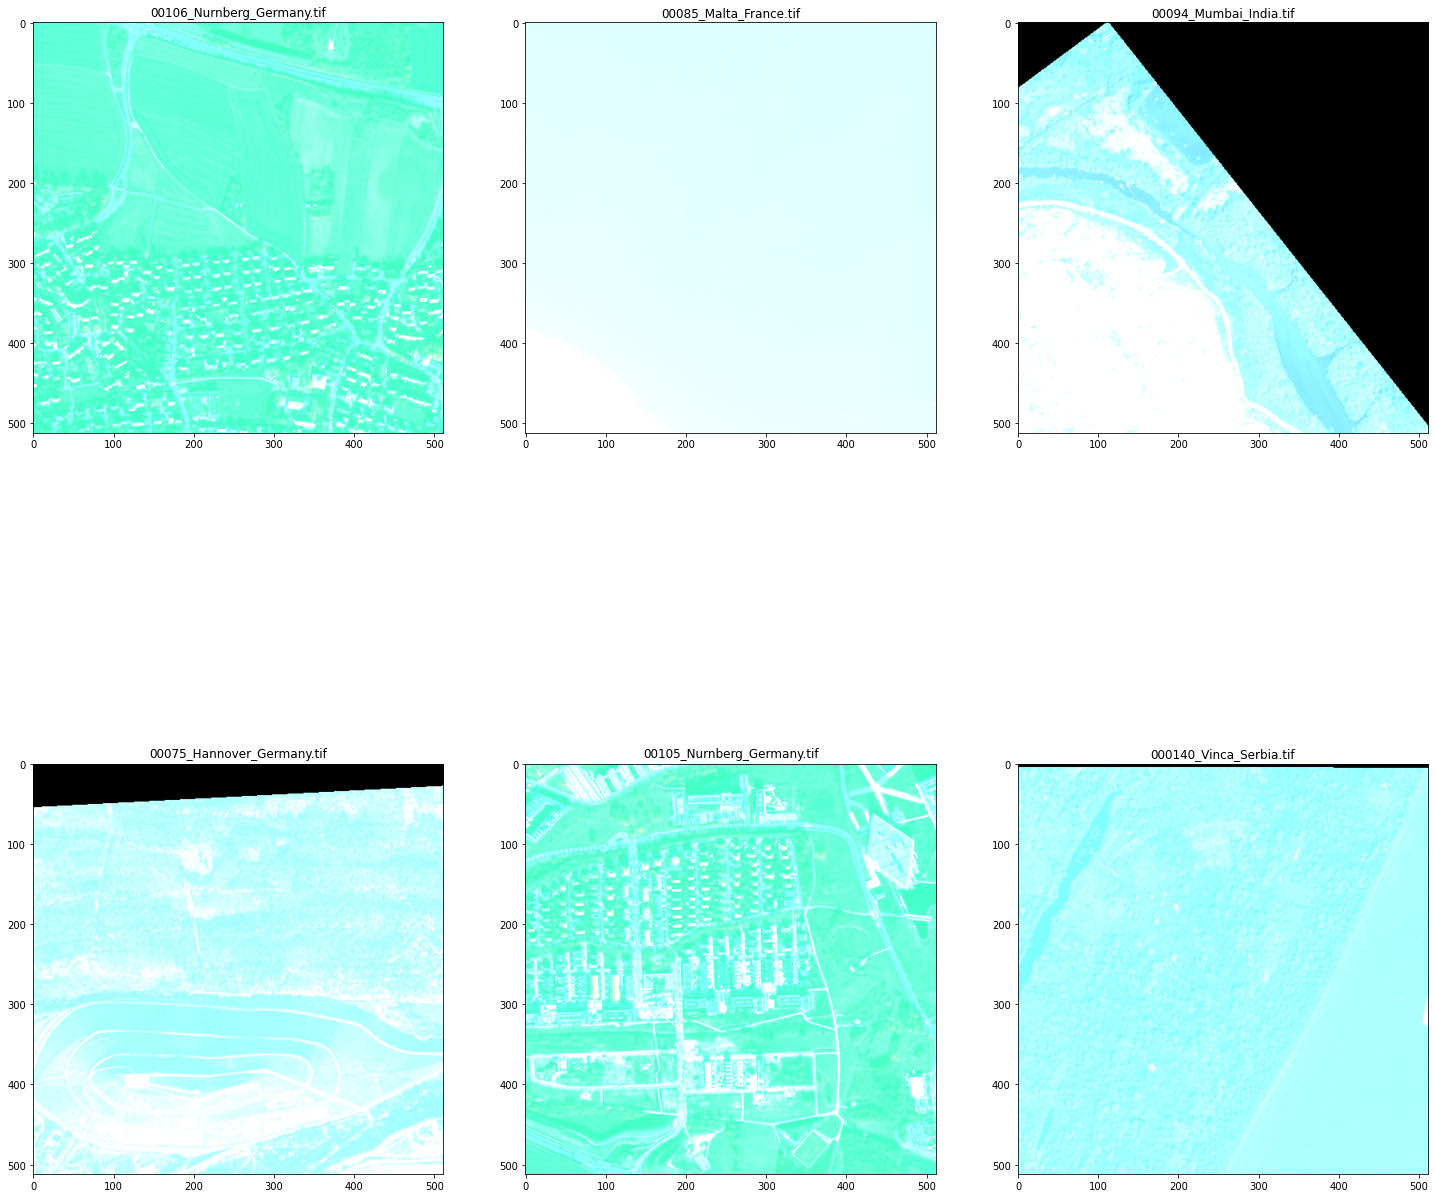

In [12]:
train_files = os.listdir(train_path)

num_of_train_images = len([name for name in train_files if os.path.isfile(os.path.join(train_path, name))])
print("Number of training images:", num_of_train_images)
selected = np.random.choice(num_of_train_images, 6)

fig = plt.figure(figsize = (25,25))
print('-------------multispectral images----------------')

for i, ind in enumerate(selected):
  raster = rasterio.open(os.path.join(train_path, train_files[ind]))
  print(raster.shape)
  raster_arr = raster.read()
  channels = raster_arr.shape[0]
  print("image : " , train_files[ind], "channels :", channels)
  #false color composite visualisation
  if(channels == 8):
    raster_fcc=np.dstack((raster_arr[4,:,:], raster_arr[2,:,:],raster_arr[1,:,:]))  
  elif(channels == 4):
    raster_fcc=np.dstack((raster_arr[2,:,:], raster_arr[1,:,:],raster_arr[0,:,:]))

  plt.subplot(2, 3, i+1)
  plt.imshow(raster_fcc)
  plt.title(train_files[ind])

Loading the dataset from the split dataset

referred from:\
https://github.com/tkshnkmr/frcnn_medium_sample,
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [117]:
from rasterio.plot import reshape_as_raster, reshape_as_image

class CustomLandfillDataset(torch.utils.data.Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #image id
    img_id = self.data[index][0]
    #path for image
    img_name = self.data[index][1]
    #read the image to extract number of channels
    raster_img = rasterio.open(os.path.join(train_path, img_name)).read()
    raster_channels = raster_img.shape[0]
    #image details
    img_info = {}
    img_info["image_id"] = img_id
    img_info["image_name"] = img_name
    img_info["raster_channels"] = raster_channels
    #print(img_info)

    return img_info

In [118]:
#parameters
batch_size = 6
num_workers = 1

Stratified and random split into train, test and validation datasets

In [146]:
train_ratio = 0.75
test_ratio = 0.15
validation_ratio = 0.10

data = pd.read_csv(train_labels, usecols=["Idx", "Image Index"]).values.tolist()
label = pd.read_csv(train_labels, usecols=["IsLandfill"]).values.tolist()
train_idx, test_idx, train_lab, test_lab = train_test_split(data, label, 
                                                            test_size = test_ratio, 
                                                            shuffle=True, stratify=label)

train_idx, val_idx, train_lab, val_lab = train_test_split(train_idx, train_lab,
                                                          test_size = validation_ratio,
                                                          shuffle=True, stratify=train_lab)


print(len(train_idx), len(test_idx), len(val_idx), len(train_lab), len(test_lab), len(val_lab))

110 22 13 110 22 13


In [147]:
train_dataset = CustomLandfillDataset(data=train_idx, transforms=None)
test_dataset = CustomLandfillDataset(data=test_idx, transforms=None)

#data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

print("length of training dataset:", len(train_dataset))
print("length of test dataset:", len(test_dataset))
print("length of training loader:", len(train_loader))
print("length of test loader:", len(test_loader))

length of training dataset: 110
length of test dataset: 22
length of training loader: 19
length of test loader: 4


Checking out some images and their corresponding masks

In [148]:
def im_convert(image_name, channels):
  image = rasterio.open(os.path.join(train_path, image_name)).read()
  #false color composite visualisation
  if(channels == 8):
    raster = np.dstack((image[4,:,:], image[2,:,:],image[1,:,:])) 
  elif(channels == 4):
    raster = np.dstack((image[2,:,:], image[1,:,:],image[0,:,:]))
  return raster

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


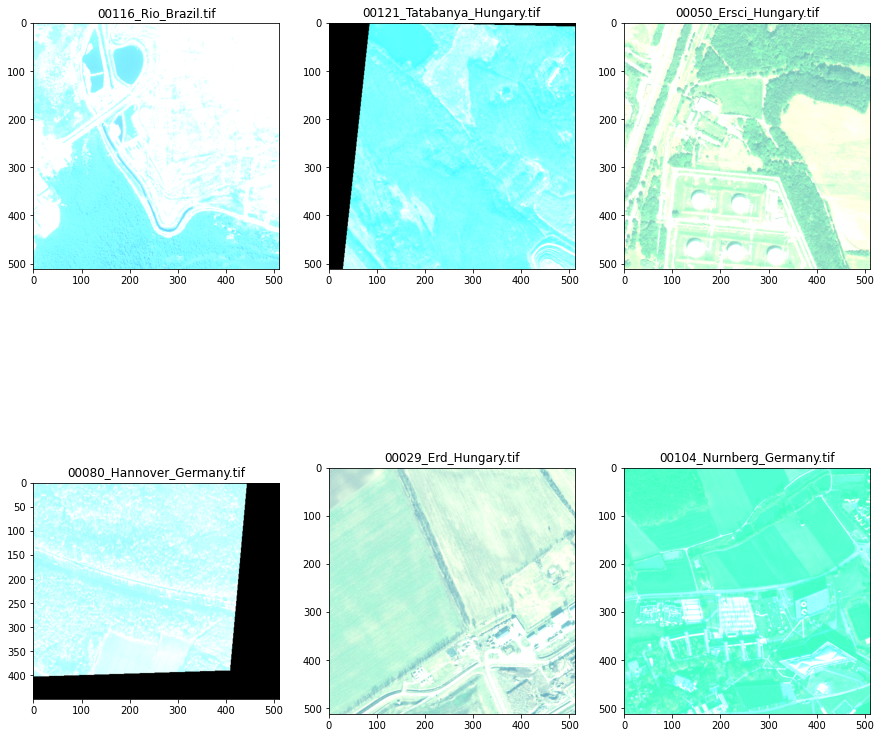

In [149]:
fig = plt.figure(figsize=(width, height))

img_info= next(iter(train_loader))
#print(img_info)

for idx in np.arange(batch_size):
  plt.subplot(2, 3, idx+1)
  id = img_info["image_id"][idx].item()
  name = img_info["image_name"][idx]
  channels = img_info["raster_channels"][idx].item()                         
  plt.imshow(im_convert(name, channels))
  plt.title(name)


Draw polygon on image:


In [150]:
json_frame = pd.read_csv(train_labels, usecols=["json index"])
json_list = json_frame.values.tolist()

for idx in np.arange(batch_size):
  id = img_info["image_id"][idx].item()
  json_name = json_list[id-1][0]
  print(json_name)
  gdf = gpd.read_file(os.path.join(json_path, json_name))

00116_Rio_Brazil.json
00121_Tatabanya_Hungary.json
00050_Ersci_Hungary.json
NoObj_Hannover.json
00029_Erd_Hungary.json
NoObj_Nurnberg.json


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

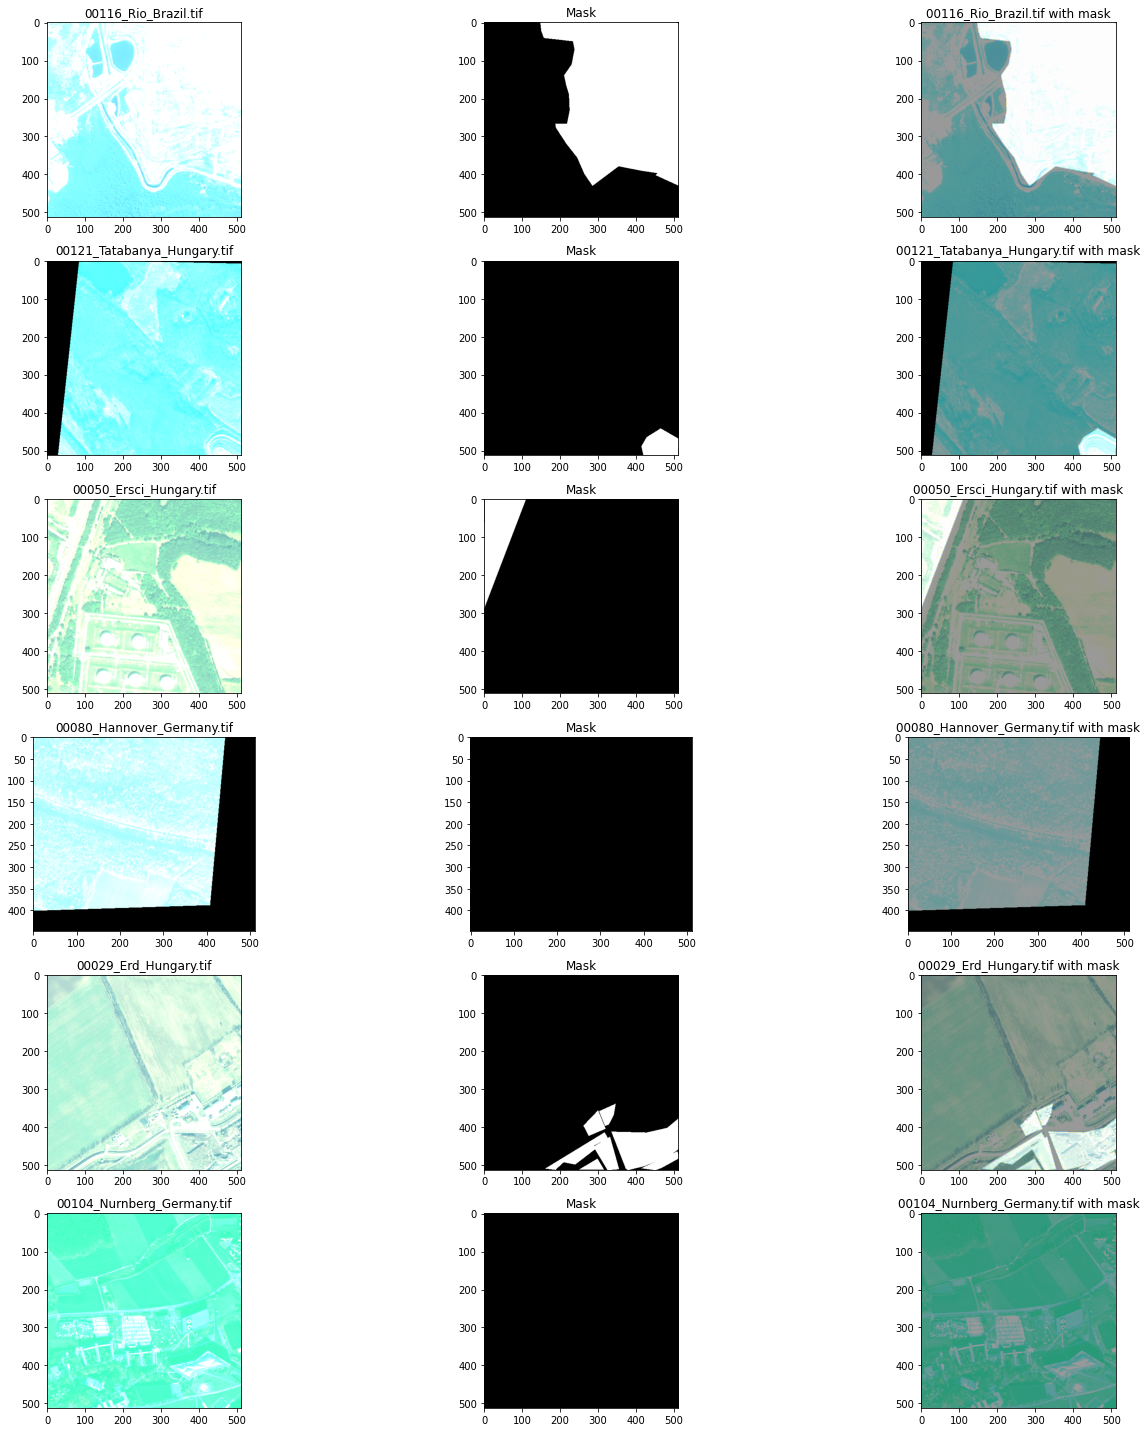

In [155]:
#fig = plt.figure(figsize=(width, height))
import cv2
count = 0
fig, axs = plt.subplots(batch_size, 3, figsize = (20, 20))
isLandfillList = pd.read_csv(train_labels, usecols=["IsLandfill"]).values.tolist()

for idx in np.arange(batch_size):
  #plt.subplot(2, 3, (idx+1))
  id = img_info["image_id"][idx].item()
  json_name = json_list[id-1][0]
  name = img_info["image_name"][idx]
  channels = img_info["raster_channels"][idx].item()  
  image = im_convert(name, channels)
  IsLandfill = isLandfillList[id-1][0]
  #print(IsLandfill)
  if(IsLandfill):
    fp_mask = sol.vector.mask.footprint_mask(df=os.path.join(json_path, json_name), reference_im=os.path.join(train_path, name))
  else:
    fp_mask = np.zeros((image.shape[0],image.shape[1]), dtype=np.uint8)
  #print(fp_mask.shape)
  axs[count][0].title.set_text(name)
  axs[count][0].imshow(image)

  axs[count][1].title.set_text('Mask')
  axs[count][1].imshow(fp_mask, cmap='gray')

  axs[count][2].title.set_text(name+" with mask")
  axs[count][2].imshow(image)
  axs[count][2].imshow(fp_mask, cmap='gist_earth', alpha=0.4)
  count += 1

fig.tight_layout()